In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

import random
import os
import unicodedata
import string

data_path = "../data/names"

In [2]:
all_letters = string.ascii_letters + " .,;"

def unicode2ascii(s):
    # Converts a unicode string to an ascii string
    return "".join(char for char in unicodedata.normalize("NFD", s)
                   if unicodedata.category(char) != "Mn"
                   and char in all_letters)

In [3]:
# Load data
# Random seed
random.seed(1235)
# Load raw data directly
n_languages = len(os.listdir(data_path))
names = []
categories = set()
for i in os.listdir(data_path):
    language, ext = os.path.splitext(i)
    language = language.lower()
    with open(os.path.join(data_path, i), encoding="utf-8") as f:
        for i in f:
            names.append({"name": i.lower().strip(),
                          "language": language})
    categories.add(language)
# make categories indexable
categories = list(categories)

# Clean all names by converting to ascii
for namedict in names:
    namedict["name"] = unicode2ascii(namedict["name"])
    
# split the data into train and test
random.shuffle(names)
# 80/20 train test split
total = len(names)
trainsplit = 0.8
point = int(total * trainsplit)
train_data, test_data = names[:point], names[point:]
print(total, len(train_data), len(test_data))
print(train_data[:5], test_data[:5])

20074 16059 4015
[{'name': 'janimov', 'language': 'russian'}, {'name': 'adrol', 'language': 'english'}, {'name': 'jahno', 'language': 'russian'}, {'name': 'binnington', 'language': 'english'}, {'name': 'tikhin', 'language': 'russian'}] [{'name': 'andryuhin', 'language': 'russian'}, {'name': 'fadeechev', 'language': 'russian'}, {'name': 'ukhabin', 'language': 'russian'}, {'name': 'danisevich', 'language': 'russian'}, {'name': 'tallett', 'language': 'english'}]


In [79]:
#Data cleaning functions
def letter2index(l):
    return all_letters.find(l)

def index2letter(i):
    return all_letters[i]

# Turn an 
def line2tensor(line):
    """
    @args
        line (str): Line to be converted to tensor form
    @returns:
        line_length x n_letters tensor containing one hot encodings
    """
    tensor = torch.zeros(len(line), len(all_letters))
    for li, letter in enumerate(line):
        tensor[li][letter2index(letter)] = 1
    return tensor

def tensor2line(tensor):
    # Takes in a L, 56 tensor and returns the string that it represents
    holder = []
    for onehot in tensor:
        holder.append(index2letter(torch.max(onehot, dim=0)[1]))
    return "".join(holder)

def tensors2line(tensors):
    holder = []
    for tensor in tensors:
        holder.append(tensor2line(tensor))
    return holder
        
        

def lines2tensor(lines):
    # Processes a string iterable and converts it to a padded, packed tensor ready for RNN ingestion
    indatas = [line2tensor(i) for i in lines]
    indatas.sort(key=lambda x: x.shape[0], reverse=True)
#     print([i.shape for i in indatas])
    indatas = pack_sequence(indatas)
#     seq_lengths = [i.shape[1] for i in indatas]
#     indatas = [i.view(-1, len(all_letters)) for i in indatas]
#     indatas = pad_sequence(indatas, batch_first=True)
#     indatas = pack_padded_sequence(indatas, seq_lengths, batch_first=True)
    return indatas

t = line2tensor("abc")
print(t, t.shape)
print(tensor2line(t))
test_packed = lines2tensor(["abc", "dhef"])
print(test_packed)
print(pad_packed_sequence(test_packed, batch_first=True)[0].shape)
        
    

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]) torch.Size([3, 56])
a

In [5]:
# Create datasets that produce tensor data
class NameDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        return self.data[x]
    
train_dataset = NameDataset(train_data)
test_dataset = NameDataset(test_data)
train_dataset = DataLoader(batch_size=32, shuffle=True, dataset=train_dataset)
test_dataset = DataLoader(batch_size=32, shuffle=True, dataset=test_dataset)
print(next(train_dataset.__iter__()))

{'name': ['bencivenni', 'bakaleinikov', 'antar', 'ghannam', 'makusev', 'shainurov', 'avtaev', 'pakhrin', 'yep', 'oneil', 'masih', 'quigley', 'agudov', 'achthoven', 'laraway', 'ahearn', 'peleev', 'tompkin', 'talbaev', 'giordano', 'boutros', 'teunissen', 'castro', 'ladyzhensky', 'adriyanoff', 'robert', 'levish', 'belin', 'oulton', 'deulin', 'mojaikin', 'guttridge'], 'language': ['italian', 'russian', 'arabic', 'arabic', 'russian', 'russian', 'russian', 'russian', 'chinese', 'english', 'arabic', 'english', 'russian', 'dutch', 'english', 'irish', 'russian', 'english', 'russian', 'italian', 'arabic', 'dutch', 'spanish', 'russian', 'russian', 'english', 'russian', 'russian', 'english', 'russian', 'russian', 'english']}


In [6]:
print(train_data[0])

{'name': 'janimov', 'language': 'russian'}


In [57]:
# Define the Neural network
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn = nn.RNN(batch_first=True, hidden_size=hidden_size, input_size=input_size)
        # Output layer to convert to the expected values
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, packed):
        _, hx = self.rnn(packed)
        # Output is of form 1, seq_count, cats
        output = self.output(hx)
        # Shape it to seq_count, cats
        return output.view(-1, self.output_size)
        
test_net = BasicRNN(len(all_letters), 128, len(categories))

In [58]:
# Figure out how sequence padding and packing work in pytorch
# Create a test array of three sequences of length (1, 3, 2)
testdata = [torch.tensor(i) for i in [[1],
                                      [1, 2, 3],
                                      [1, 2]]]
# Sort the sequences in decreasing order cause pytorch wants it that way
testdata.sort(reverse=True, key=lambda x: len(x))

# seq_lengths = [len(i) for i in testdata]

# This whole part outmoded by
# # Pad the data with zeros so that these variable length sequences are of the same length
# # batch_first = True cause I like the batches to be first
# padded = pad_sequence(testdata, batch_first=True)
# print(padded)
# # Pack the sequence
# packed = pack_padded_sequence(padded, seq_lengths, batch_first=True)
# print(packed)
packed = pack_sequence(testdata)
print(packed)
pad_packed_sequence(packed, batch_first=True)

PackedSequence(data=tensor([ 1,  1,  1,  2,  2,  3]), batch_sizes=tensor([ 3,  2,  1]))


(tensor([[ 1,  2,  3],
         [ 1,  2,  0],
         [ 1,  0,  0]]), tensor([ 3,  2,  1]))

In [59]:
sample_data = next(train_dataset.__iter__())

In [80]:
# Test out the pytorch RNN implementation
# RNN params
hidden_size = 128
input_size = len(all_letters)
output_size = n_languages

# testdata
names = sample_data["name"][:3]
print(names)

# Convert to tensor sequences

# Pack the names to handle variable length input
packed_names = lines2tensor(names)


# Example of how the RNN class works
net = nn.RNN(batch_first=True, hidden_size=hidden_size, input_size=input_size)

print(packed_names)

packed_output, hx = net(packed_names)
print("RNN output HX: ", hx.shape)
# Feed into a linear layer to get output (untrained)
nn.Linear(128, 10)(hx)

# Basic RNN based on the RNN class
net = BasicRNN(hidden_size=hidden_size, input_size=input_size, output_size = output_size)
output = net(packed_names)

print(output.shape)
softmaxed = F.softmax(output, dim=1)
print(softmaxed)
print(softmaxed.shape)
print("These should all be one")
print(softmaxed.sum(dim=1))

# OLD
# Test parallel RNN execution
# pytorch RNN takes input of form (B, S, F) since batch_first is used


# indatas = [line2tensor(i) for i in names]
# indatas.sort(key=lambda x: x.shape[1], reverse=True)
# seq_lengths = [i.shape[1] for i in indatas]
# print(seq_lengths)
# indatas = [i.view(-1, len(all_letters)) for i in indatas]
# print([i.shape for i in indatas])
# indatas = pad_sequence(indatas, batch_first=True)
# print(indatas.shape)
# indatas = pack_padded_sequence(indatas, seq_lengths, batch_first=True)


['salamanca', 'windsor', 'mozhin']
PackedSequence(data=tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.]]), batch_sizes=tensor([ 3,  3,  3,  3,  3,  3,  2,  1,  1]))
RNN output HX:  torch.Size([1, 3, 128])
torch.Size([3, 18])
tensor(1.00000e-02 *
       [[ 5.1837,  5.0056,  6.1426,  5.3347,  5.1278,  6.3156,  5.2563,
          5.9159,  5.6195,  5.7671,  5.5178,  5.4083,  5.2057,  6.0908,
          6.0268,  5.3849,  5.6299,  5.0669],
        [ 4.7370,  4.9136,  6.5397,  5.2144,  5.2133,  6.0095,  5.0403,
          6.1807,  5.5723,  5.7727,  5.5756,  5.1264,  5.1509,  5.6095,
          6.2172,  6.3172,  5.5561,  5.2537],
        [ 5.2140,  4.6636,  6.1361,  5.3398,  5.4716,  6.0890,  5.1352,
          6.0093,  5.7362,  5.6305,  5.2479,  5.0521,  5.3651, 

In [76]:
def tensor2index_tensor(tensor):
    # Converts a tensor of outputs (one-hot encoded) to a tensor of indicies
    # Here, we're expecting them to be of form (n, catsize), where n is the number of samples
    # returns a tensor of form (n) containing the indices
    return F.softmax(tensor, dim=1).max(dim=1)[1]

def index_tensor2cat(index_tensor):
    # Converts an index tensor to a list of categories
    return [categories[i] for i in index_tensor]


def cat2index(cat):
    return categories.index(cat)

def cat2index_tensor(cat):
    dat = [cat2index(cat)]
    return torch.tensor(dat, dtype=torch.long)

def cats2index_tensor(cats):
    dat = [cat2index(cat) for cat in cats]
    return torch.tensor(dat, dtype=torch.long)

# def index_tensor2tensor(index_tensor, cat_size=len(categories)):
#     # Converts an index tensor to a one hot encoding of 
    

print(output, output.shape)
idx_tensor = tensor2indextensor(output)
print(idx_tensor)
print(index_tensor2cat(idx_tensor))
print(cat2index("portuguese"))
print(cat2index_tensor("portuguese"))
# Note: Cross Entropy log does the log_softmax then a NLLoss. 
# Expects input of raw output values, target of just the expected index
criterion = nn.CrossEntropyLoss()
loss = criterion(output, cats2index_tensor(["portuguese", "german", "chinese"]))
print(loss/3)
loss = criterion(output, cats2index_tensor(["chinese", "german", "chinese"]))
print(loss/3)

tensor([[ 0.0814,  0.1730, -0.0733,  0.0006,  0.0747, -0.0025, -0.0081,
         -0.0308, -0.1275, -0.0787,  0.1349, -0.0764,  0.0239,  0.0004,
         -0.0684, -0.0827, -0.0473,  0.1088],
        [ 0.0813,  0.0670, -0.0555,  0.0175,  0.0432,  0.0138,  0.0881,
          0.0149, -0.1118, -0.0031,  0.0067, -0.0811,  0.0815, -0.0060,
         -0.0539, -0.0442, -0.0165,  0.0439],
        [ 0.0738,  0.1236, -0.0318,  0.0284,  0.0561, -0.0045,  0.0712,
         -0.0040, -0.0632, -0.0240,  0.0862, -0.0131,  0.0468, -0.0171,
          0.0049, -0.0996, -0.0875,  0.0564]]) torch.Size([3, 18])
tensor([ 1,  6,  1])
['chinese', 'german', 'chinese']
12
tensor([ 12])
tensor(0.9398)
tensor(0.9233)


In [107]:
hidden_size = 128
input_size = len(all_letters)
output_size = n_languages
net = BasicRNN(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.005)
# net.cuda()
epochs = 10
losses  = []
running_loss = 0
for epoch in range(epochs):
    for batchnum, minibatch in enumerate(train_dataset):
        # Zero out the previous gradients
        optim.zero_grad()
        names, languages = minibatch["name"], minibatch["language"]
        # Create the data tensors to be used
        input_tensor = lines2tensor(names)
        target_tensor = cats2index_tensor(languages)
        output = net(input_tensor)
        loss = criterion(output, target_tensor)
        # Minibatch optimization
        loss.backward()
        
        running_loss += loss
        # Print every 100 batches
        if batchnum % 100 == 99:
            losses.append(running_loss)
            print(f"Epoch: {epoch}; Batch: {batchnum}; Loss: {running_loss/100}")
            running_loss = 0
    optim.step()

Epoch: 0; Batch: 99; Loss: 2.841360569000244
Epoch: 0; Batch: 199; Loss: 2.8402509689331055
Epoch: 0; Batch: 299; Loss: 2.8420932292938232
Epoch: 0; Batch: 399; Loss: 2.839658498764038
Epoch: 0; Batch: 499; Loss: 2.841223955154419
Epoch: 1; Batch: 99; Loss: 2.7059319019317627
Epoch: 1; Batch: 199; Loss: 2.646411418914795
Epoch: 1; Batch: 299; Loss: 2.644838571548462
Epoch: 1; Batch: 399; Loss: 2.6461188793182373
Epoch: 1; Batch: 499; Loss: 2.644071340560913
Epoch: 2; Batch: 99; Loss: 2.342114210128784
Epoch: 2; Batch: 199; Loss: 2.2967958450317383
Epoch: 2; Batch: 299; Loss: 2.302952766418457
Epoch: 2; Batch: 399; Loss: 2.2789788246154785
Epoch: 2; Batch: 499; Loss: 2.2747859954833984
Epoch: 3; Batch: 99; Loss: 2.0026121139526367
Epoch: 3; Batch: 199; Loss: 1.981723666191101
Epoch: 3; Batch: 299; Loss: 1.9475895166397095
Epoch: 3; Batch: 399; Loss: 1.956693410873413
Epoch: 3; Batch: 499; Loss: 2.0010578632354736
Epoch: 4; Batch: 99; Loss: 2.104062795639038
Epoch: 4; Batch: 199; Loss: 2

In [110]:
# test out our little network
correct, wrong, total = 0, 0, 0
for minibatch in test_dataset:
    names, languages = minibatch["name"], minibatch["language"]
    indata_tensor, target_tensor = lines2tensor(names), cats2index_tensor(languages)
    # Raw outputs
    output = net(indata_tensor)
    output = tensor2index_tensor(output)
    total += len(names)
    correct += (output == target_tensor).sum()
    wrong += (output != target_tensor).sum()

print(f"Correct: {correct}/{total}, {correct/total}")
print(f"Wrong: {wrong}/{total}, {wrong/total}")
    

Correct: 1881/4015, 0
Wrong: 2134/4015, 0


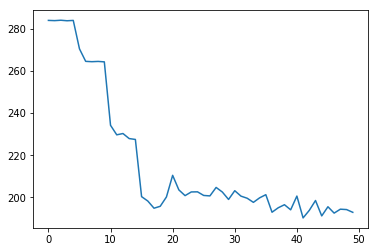

In [109]:
import matplotlib.pyplot as plt
plt.plot(losses)

502
